In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
# loading the datasets
youtube_, davidson = pd.read_csv('final.csv'), pd.read_csv('modified_davidson.csv')
print(youtube.head(), davidson.head())
# in case of davidson and youtube, [a, b, c] is abusive, hate, clean

                                                text      label
0            mr. mine you say babe what's yeah first  [0, 0, 1]
1  mr. mine you say babe what's yeah first of a d...  [0, 0, 1]
2            of a dynamic punch get it good mr. line  [0, 0, 1]
3  of a dynamic punch get it good mr. line you'll...  [0, 0, 1]
4               you'll get stronger glabra it's your  [0, 0, 1]                                                 text      label
0  as a woman you shouldnt complain about cleanin...  [0, 0, 1]
1  boy dats coldtyga dwn bad for cuffin dat hoe i...  [1, 0, 0]
2  dawgyou ever fuck a bitch and she start to cry...  [1, 0, 0]
3                             she look like a tranny  [1, 0, 0]
4  the shit you hear about me might be true or it...  [1, 0, 0]


In [16]:
# creating the text dataset for training
youtube = youtube_[['text', 'label']]
print(youtube.groupby('label').count(), davidson.groupby('label').count())

           text
label          
[0, 0, 1]  5298
[0, 1, 0]   244
[1, 0, 0]   456
[1, 1, 0]   824             text
label           
[0, 0, 1]   4162
[0, 1, 0]   1430
[1, 0, 0]  19189


As seen, there are 4 categories, viz. Abusive, Hate, abusive + hate, and clean.

| Category | Samples |
| :---:    | :---: |
| Abusive |  19189 + 456 | 
| Hate | 1430 + 244  |
| Abusive + Hate | 0 + 824 |
| Clean | 4162 + 5298 |

In [46]:
SEED_PERCENT = 0.2
test_sample = youtube.groupby('label').apply(lambda x: x.sample(frac=SEED_PERCENT))
test_sample.reset_index(drop=True, inplace=True)
dataset = pd.merge(davidson, test_sample, on=['text', 'label'], how='outer')
dataset.to_csv('comb_data.csv', index=False)
dataset.groupby('label').count()

,text
label,
"[0, 0, 1]",5222
"[0, 1, 0]",1479
"[1, 0, 0]",19280
"[1, 1, 0]",165


## Training the model

Now that the dataset is prepared, we can proceed to training and compiling the model.

In [47]:
dataset = pd.read_csv('comb_data.csv')
dataset.head()

,text,label
0,as a woman you shouldnt complain about cleanin...,"[0, 0, 1]"
1,boy dats coldtyga dwn bad for cuffin dat hoe i...,"[1, 0, 0]"
2,dawgyou ever fuck a bitch and she start to cry...,"[1, 0, 0]"
3,she look like a tranny,"[1, 0, 0]"
4,the shit you hear about me might be true or it...,"[1, 0, 0]"


In [132]:
import numpy as np
embedding_ = np.load('embeddings.npy')
embedding_.shape

(22338, 256)

In [141]:
from keras.models import Sequential, load_model, save_model
from keras.layers import Embedding, Dropout, Bidirectional, LSTM, Dense
INPUT_SIZE = 128
def get_model(embedding, vocab_size=INPUT_SIZE):
    model = Sequential()
    model.add(Embedding(*embedding.shape, weights=[embedding], input_length=vocab_size, name='Embedding_Layer'))
    model.add(Dropout(0.5, name="Dropout"))
    model.add(Bidirectional(LSTM(2 * vocab_size, dropout=0.3, recurrent_dropout=0.2, return_sequences=True, name="Bi-LSTM_Layer_1")))
    model.add(Bidirectional(LSTM(vocab_size, dropout=0.4, recurrent_dropout=0.1, name="Bi-LSTM_Layer_2")))

    model.add(Dense(64, activation='relu', name="Dense_64"))
    model.add(Dense(32, activation='relu', name="Dense_32"))
    model.add(Dense(3, activation='sigmoid',name='Dense_3'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy', 'accuracy'])
    print(model.summary())
    return model


model = get_model(embedding_, INPUT_SIZE)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_Layer (Embedding)  (None, 128, 256)          5718528   
_________________________________________________________________
Dropout (Dropout)            (None, 128, 256)          0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 128, 512)          1050624   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 256)               656384    
_________________________________________________________________
Dense_64 (Dense)             (None, 64)                16448     
_________________________________________________________________
Dense_32 (Dense)             (None, 32)                2080      
_________________________________________________________________
Dense_3 (Dense)              (None, 3)                 99        
Total para

In [142]:
# model training
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from ast import literal_eval
_X, _y = dataset['text'].astype('str'), dataset['label']

tokenizer = Tokenizer(num_words=INPUT_SIZE)  # keeps all the words
tokenizer.fit_on_texts(_X)
X = tokenizer.texts_to_matrix(_X)
y = np.array(list(map(lambda label: literal_eval(label), _y)))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69, test_size=0.0)
X_train.shape, X_test.shape

((26148, 128), (0, 128))

In [ ]:
# train the model
from keras_tqdm import TQDMNotebookCallback
import datetime
history = model.fit(X_train, y_train, batch_size=128, epochs=4, validation_split=0.2, verbose=0, callbacks=[TQDMNotebookCallback()])
model_name = f"model_{datetime.datetime.now()}.h5"
model.save(model_name)

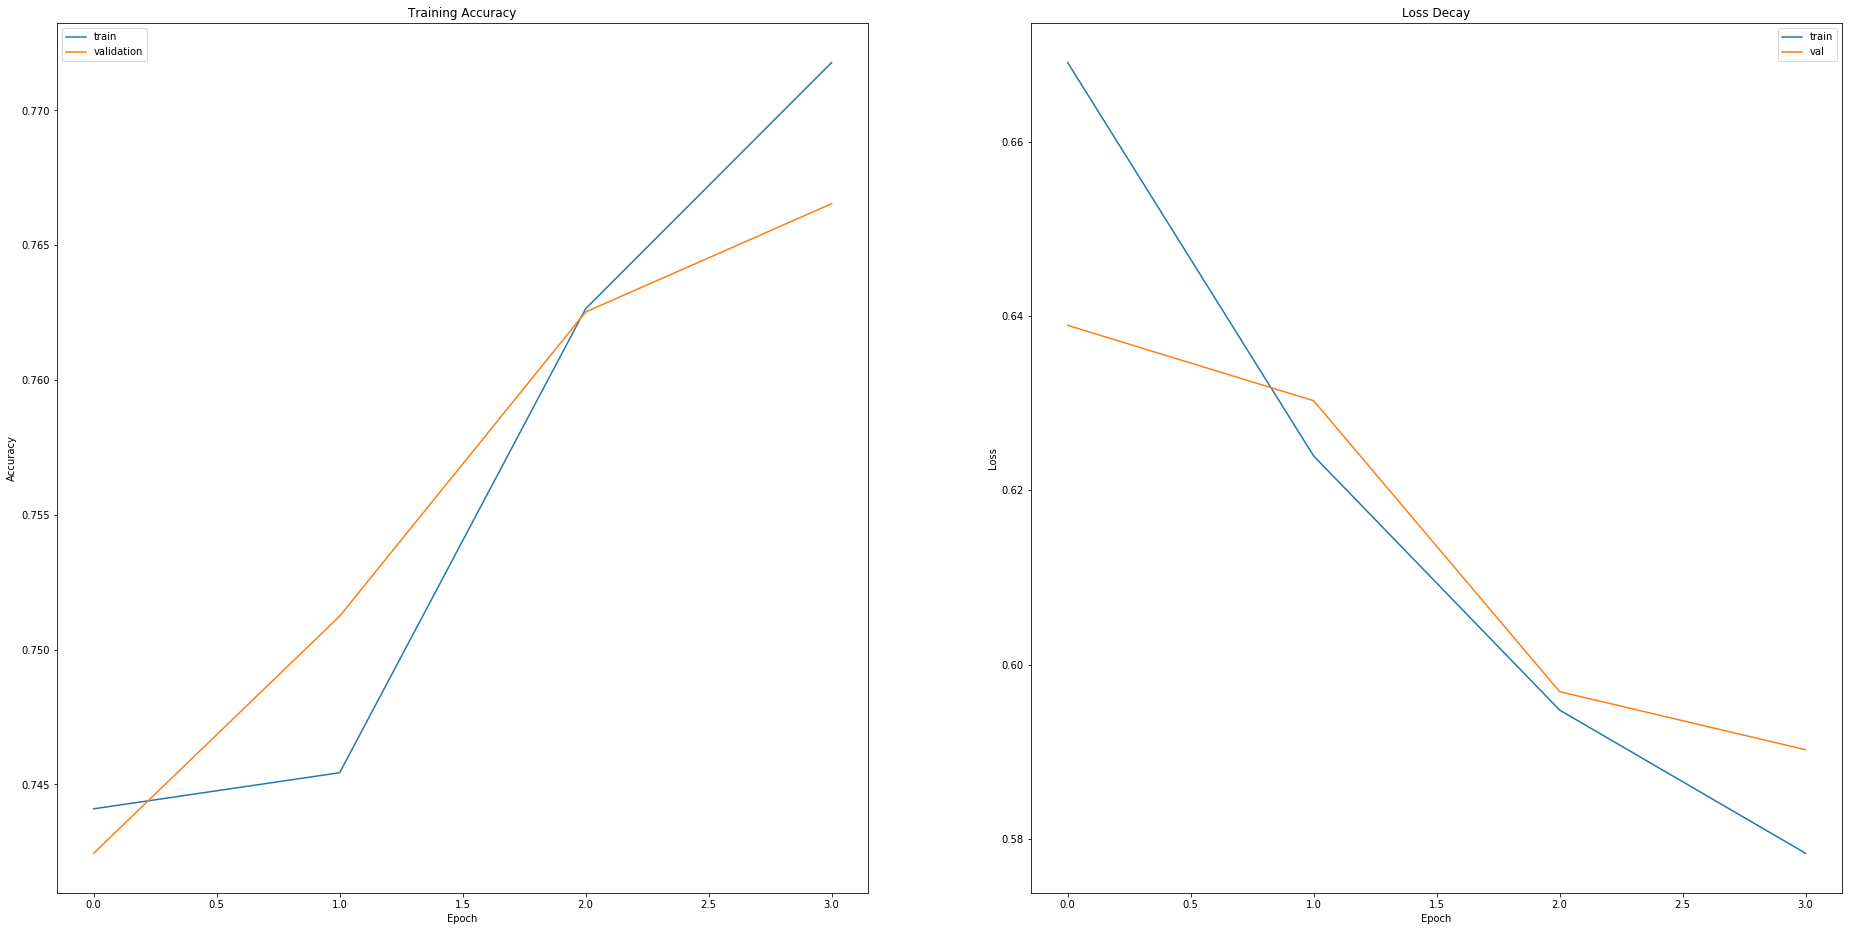

In [91]:
fig = plt.figure(figsize=(32, 16))
fig.add_subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train', 'validation'], loc='upper left')
plt.title("Training Accuracy")
plt.xlabel("Epoch"), plt.ylabel("Accuracy")
fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Decay')
plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

## Model Evaluation and testing

Now that we've trained the model, it's time to test it against some real world data.

In [98]:
from keras.utils import plot_model
test_df = pd.read_csv('final.csv')[['text', 'label']]
# model = load_model(model_name)  # change this to the corresponding model file
# plot_model(model, to_file='model.png')
print(test_df.head())
print(model.summary())

                                                text      label
0            mr. mine you say babe what's yeah first  [0, 0, 1]
1  mr. mine you say babe what's yeah first of a d...  [0, 0, 1]
2            of a dynamic punch get it good mr. line  [0, 0, 1]
3  of a dynamic punch get it good mr. line you'll...  [0, 0, 1]
4               you'll get stronger glabra it's your  [0, 0, 1]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 128, 512)          11437056  
_________________________________________________________________
dropout_6 (Dropout)          (None, 128, 512)          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               295424    
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
______________________

In [127]:
_X_test, y_test = test_df.text, np.array([literal_eval(_) for _ in test_df.label.values.tolist()])
X_test = tokenizer.texts_to_matrix(_X_test)
X_test.shape

(6822, 128)

In [115]:
y_hat = model.predict(X_test)

In [131]:
from sklearn.metrics import classification_report
y_hat = to_categorical([np.argmax(_) for _ in y_hat]).astype('int')
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.22      0.79      0.35      1280
           1       0.00      0.00      0.00      1068
           2       0.86      0.37      0.52      5298

   micro avg       0.44      0.39      0.41      7646
   macro avg       0.36      0.39      0.29      7646
weighted avg       0.63      0.39      0.42      7646
 samples avg       0.44      0.39      0.40      7646

